# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [127]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import progressbar
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [7]:
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
feat_info.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 5 columns):
Unnamed: 0     0 non-null float64
Attribute      314 non-null object
Description    351 non-null object
Value          2258 non-null object
Meaning        2247 non-null object
dtypes: float64(1), object(4)
memory usage: 88.3+ KB


In [9]:
feat_info = feat_info.drop(['Unnamed: 0'], axis=1)
feat_info.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [10]:
feat_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


### Part 0.1: Match the number of features 

After knowing the number of the features which did not match between feat_info attribute and azdias column, we will explore deeper

In [11]:
feat_info2 = feat_info.copy()
feat_info_attribute = feat_info['Attribute'].fillna(method='ffill')
feat_info2['Attribute'] = feat_info_attribute
feat_info2.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [ ]:
feat_info2.to_csv("feat_info2.csv", header=True)

In [ ]:
feat_info2 = pd.read_csv("feat_info2.csv")
feat_info2 = feat_info2.drop(['Unnamed: 0'], axis=1)
feat_info2.head()

In [12]:
in_az = []
not_in_az = []
for row in feat_info2['Attribute'].value_counts().index:
    if row in azdias.columns:
        in_az.append(row)
    else:
        not_in_az.append(row)

In [13]:
len(not_in_az)

42

In [14]:
not_in_az

['CAMEO_DEUINTL_2015',
 'HAUSHALTSSTRUKTUR',
 'D19_HANDWERK_RZ',
 'D19_TECHNIK_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_FREIZEIT_RZ',
 'D19_KOSMETIK_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_TELKO_REST_RZ',
 'D19_LOTTO_RZ',
 'D19_BANKEN_DIREKT_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_RATGEBER_RZ',
 'D19_BUCH_RZ',
 'D19_SONSTIGE_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_ENERGIE_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_REISEN_RZ',
 'GEOSCORE_KLS7',
 'D19_GARTEN_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'KBA13_CCM_1400_2500',
 'D19_KK_KUNDENTYP',
 'WACHSTUMSGEBIET_NB',
 'SOHO_FLAG',
 'BIP_FLAG']

In [15]:
in_feat = []
not_in_feat = []
for col in azdias.columns:
    if col in feat_info2['Attribute'].value_counts().index:
        in_feat.append(col)
    else:
        not_in_feat.append(col)

In [16]:
len(not_in_feat)

94

In [17]:
not_in_feat 

['LNR',
 'AKT_DAT_KL',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSI_DATUM

We can see that there are differences in the features that are being explained by feat_info2 and azdias. The features that are being explained in feat_info2 but did not appear in azdias is fine; however, the features in the azdias which cannot be explained might hinder during the interpretation of the analysis. We seperate the "not_in_feat" features into two parts manually: The one that have almost similar name such as D19_REISEN -> D19_REISEN_KZ and the one that does not have any similarity which will be dropped from our analysis.

In [24]:
final_not_in_feat = ['LNR',
 'AKT_DAT_KL',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_KONSUMTYP_MAX',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSI_ONLINE_QUOTE_12',
 'DSL_FLAG',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'FIRMENDICHTE',
 'GEMEINDETYP',
 'HH_DELTA_FLAG',
 'KBA13_ANTG1',
 'KBA13_ANTG2',
 'KBA13_ANTG3',
 'KBA13_ANTG4',
 'KBA13_BAUMAX',
 'KBA13_GBZ',
 'KBA13_HHZ',
 'KBA13_KMH_210',
 'KOMBIALTER',
 'KONSUMZELLE',
 'MOBI_RASTER',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'UNGLEICHENN_FLAG',
 'VERDICHTUNGSRAUM',
 'VHA',
 'VHN',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11']

In [18]:
azdias2 = azdias.drop(['LNR',
 'AKT_DAT_KL',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_KONSUMTYP_MAX',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSI_ONLINE_QUOTE_12',
 'DSL_FLAG',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'FIRMENDICHTE',
 'GEMEINDETYP',
 'HH_DELTA_FLAG',
 'KBA13_ANTG1',
 'KBA13_ANTG2',
 'KBA13_ANTG3',
 'KBA13_ANTG4',
 'KBA13_BAUMAX',
 'KBA13_GBZ',
 'KBA13_HHZ',
 'KBA13_KMH_210',
 'KOMBIALTER',
 'KONSUMZELLE',
 'MOBI_RASTER',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'UNGLEICHENN_FLAG',
 'VERDICHTUNGSRAUM',
 'VHA',
 'VHN',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11'], axis=1)

In [19]:
azdias2 = azdias2.rename(columns = {'CAMEO_INTL_2015':'CAMEO_DEUINTL_2015', 'D19_KOSMETIK': 'D19_KOSMETIK_RZ', 'D19_BANKEN_LOKAL': 'D19_BANKEN_LOKAL_RZ',
                                    'D19_BANKEN_REST':'D19_BANKEN_REST_RZ', 'D19_BANKEN_GROSS':'D19_BANKEN_GROSS_RZ', 'D19_BEKLEIDUNG_GEH': 'D19_BEKLEIDUNG_GEH_RZ',
                                    'D19_BANKEN_DIREKT':'D19_BANKEN_DIREKT_RZ', 'D19_BEKLEIDUNG_REST': 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG': 'D19_BILDUNG_RZ',
                                    'D19_BIO_OEKO':'D19_BIO_OEKO_RZ', 'D19_BUCH_CD':'D19_BUCH_RZ', 'D19_DIGIT_SERV':'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL':'D19_DROGERIEARTIKEL_RZ',
                                    'D19_ENERGIE': 'D19_ENERGIE_RZ', 'D19_FREIZEIT':'D19_FREIZEIT_RZ', 'D19_GARTEN':'D19_GARTEN_RZ', 'D19_HANDWERK': 'D19_HANDWERK_RZ', 
                                    'D19_HAUS_DEKO':'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL':'D19_KINDERARTIKEL_RZ', 'D19_LEBENSMITTEL': 'D19_LEBENSMITTEL_RZ', 
                                    'D19_NAHRUNGSERGAENZUNG':'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER':'D19_RATGEBER_RZ', 'D19_REISEN': 'D19_REISEN_RZ', 
                                    'D19_SAMMELARTIKEL':'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE': 'D19_SCHUHE_RZ', 'D19_TELKO_REST': 'D19_TELKO_REST_RZ',  
                                    'D19_SONSTIGE':'D19_SONSTIGE_RZ', 'D19_TELKO_MOBILE': 'D19_TELKO_MOBILE_RZ', 'D19_TECHNIK': 'D19_TECHNIK_RZ',
                                    'D19_VOLLSORTIMENT': 'D19_VOLLSORTIMENT_RZ', 'D19_TIERARTIKEL':'D19_TIERARTIKEL_RZ', 'D19_VERSICHERUNGEN': 'D19_VERSICHERUNGEN_RZ',
                                    'SOHO_KZ':'SOHO_FLAG', 'KBA13_CCM_1401_2500': 'KBA13_CCM_1400_2500', 'D19_VERSAND_REST':'D19_VERSAND_REST_RZ', 
                                    'D19_WEIN_FEINKOST':'D19_WEIN_FEINKOST_RZ', 'D19_LOTTO': 'D19_LOTTO_RZ', 'KK_KUNDENTYP': 'D19_KK_KUNDENTYP'
})

In [20]:
azdias2['CAMEO_DEUINTL_2015'].value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_DEUINTL_2015, dtype: int64

In [22]:
#azdias2.to_csv("azdias2.csv", header=True)

In [38]:
#azdias2 = pd.read_csv("azdias2.csv")
#azdias2 = azdias2.drop(['Unnamed: 0'], axis=1)
#azdias2.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_DEUINTL_2015,...,SHOPPER_TYP,SOHO_FLAG,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,-1,NaN,NaN,NaN,3,1,2
1,-1,0.0,11.0,0.0,2.0,0.0,6.0,8A,8,51,...,3,1.0,0.0,2,3.0,9.0,4.0,5,2,1
2,-1,17.0,10.0,0.0,1.0,0.0,2.0,4C,4,24,...,2,0.0,0.0,1,3.0,9.0,2.0,5,2,3
3,2,13.0,1.0,0.0,0.0,0.0,4.0,2A,2,12,...,1,0.0,0.0,1,NaN,9.0,7.0,3,2,4
4,-1,20.0,3.0,0.0,4.0,0.0,2.0,6B,6,43,...,2,0.0,0.0,2,2.0,9.0,3.0,4,1,3


### Part 0.2: Converting Unknown into NaN
At this part, we will convert all of the features that have classfication of the "unknown" answers such as -1 and 0 and turned it into NaN. But first, we will watch closely for those that are have string dtypes as some of them have weird value of X and XX.  

In [41]:
azdias2.select_dtypes(include='object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_DEUINTL_2015,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,8,51,W
2,4C,4,24,W
3,2A,2,12,W
4,6B,6,43,W


In [42]:
azdias2['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [43]:
azdias2['CAMEO_DEU_2015'].value_counts()

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64

In [44]:
azdias2['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [45]:
azdias2['CAMEO_DEUG_2015'].replace(['X'], np.nan, inplace=True)
azdias2['CAMEO_DEU_2015'].replace(['XX'], np.nan, inplace=True)
azdias2['CAMEO_DEUINTL_2015'].replace(['XX'], np.nan, inplace=True)

We replaced all of the X and XX values of string-type columns with NaN as there is no explanation of the X and XX values at the feat_info 

In [46]:
feat_info2['Meaning'].value_counts()

unknown                                                     232
average                                                     162
high                                                        154
low                                                         154
very high                                                   142
very low                                                    139
none                                                        138
Singlebuyer 0-12 months                                      34
Prospects > 24 months                                        34
Buyer > 24 months                                            34
Singlebuyer 13-24 months                                     34
Multi-/Doublebuyer 13-24 months                              34
Multibuyer 0-12 months                                       34
Doublebuyer 0-12 months                                      34
no transaction known                                         34
no transactions known                   

In [68]:
feat_nan = feat_info2[feat_info2['Meaning'].str.contains('unknown', na=False)]
feat_nan

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown


In [69]:
nan = []

for attribute in feat_nan['Attribute'].unique():
    val = feat_nan.loc[feat_nan['Attribute'] == attribute, 
                                        'Value'].astype(str).str.cat(sep=',').split(',')
    nan.append(val)

feat_nan = pd.concat([pd.Series(feat_nan['Attribute'].unique()), pd.Series(nan)], axis=1)
feat_nan.columns = ['Attribute', 'missing_or_unknown']
feat_nan

,Attribute,missing_or_unknown
0,AGER_TYP,[-1]
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
5,BIP_FLAG,[-1]
6,CAMEO_DEUG_2015,[-1]
7,CAMEO_DEUINTL_2015,[-1]
8,CJT_GESAMTTYP,[0]
9,D19_KK_KUNDENTYP,[-1]


In [70]:
for row in feat_nan['Attribute']:
    print(row)
    if row in azdias2.columns:
        na_map = feat_nan.loc[feat_nan['Attribute'] == row, 'missing_or_unknown'].iloc[0]
        na_idx = azdias2.loc[:, row].isin(na_map)
        azdias2.loc[na_idx, row] = np.NaN
    else:
        continue

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_KK_KUNDENTYP
EWDICHTE
FINANZTYP
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
HEALTH_TYP
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_AUTOQUOT
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA05_DIESEL
KBA05_FRAU
KBA05_GBZ
KBA05_HERST1
KBA05_HERST2
KBA05_HERST3
KBA05_HERST4
KBA05_HERST5
KBA05_HERSTTEMP
KBA05_KRSAQUOT
KBA05_KRSHERST1
KBA05_KRSHERST2
KBA05_KRSHERST3
KBA05_KRSKLEIN
KBA05_KRSOBER
KBA05_KRSVAN
KBA05_KRSZUL
KBA05_KW1
KBA05_KW2
KBA05_KW3
KBA05_MAXAH
KBA05_MAXBJ
KBA05_MAXHERST
KBA05_MAXSEG
KBA05_MAXVORB
KBA05_MOD1
KBA05_MOD2
KBA05_MOD3
KBA05_MOD4
KBA05_MOD8
KBA05_MODTEMP
KBA05_MOTOR
KBA05_MOTRAD
KBA05_SEG1
KBA05_SEG10
KBA05_SEG2
KBA05_SEG3
KBA05_S

/opt/conda/lib/python3.6/site-packages/pandas/core/internals.py:389: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  self.values = np.delete(self.values, loc, 0)
/opt/conda/lib/python3.6/site-packages/pandas/core/internals.py:390: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  self.mgr_locs = self.mgr_locs.delete(loc)


REGIOTYP
RELAT_AB
RETOURTYP_BK_S
SEMIO_DOM
SEMIO_ERL
SEMIO_FAM
SEMIO_KAEM
SEMIO_KRIT
SEMIO_KULT
SEMIO_LUST
SEMIO_MAT
SEMIO_PFLICHT
SEMIO_RAT
SEMIO_REL
SEMIO_SOZ
SEMIO_TRADV
SEMIO_VERT
SHOPPER_TYP
SOHO_FLAG
TITEL_KZ
VERS_TYP
WOHNDAUER_2008
WOHNLAGE
WACHSTUMSGEBIET_NB
W_KEIT_KIND_HH
ZABEOTYP


In [71]:
azdias2.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_DEUINTL_2015,...,SHOPPER_TYP,SOHO_FLAG,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,NaN,NaN,11.0,0.0,2.0,0.0,6.0,8A,8,51,...,3.0,1.0,NaN,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,NaN,17.0,10.0,0.0,1.0,0.0,2.0,4C,4,24,...,2.0,0.0,NaN,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,2.0,13.0,1.0,0.0,0.0,0.0,4.0,2A,2,12,...,1.0,0.0,NaN,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,NaN,20.0,3.0,0.0,4.0,0.0,2.0,6B,6,43,...,2.0,0.0,NaN,2.0,2.0,9.0,3.0,4.0,1.0,3.0


In [72]:
#azdias2.to_csv("azdias3.csv", header=True)

In [73]:
#feat_nan.to_csv("feat_nan.csv", header=True)

In [74]:
#azdias3 = pd.read_csv("azdias3.csv")
#azdias3 = azdias3.drop(['Unnamed: 0'], axis=1)
#azdias3.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_DEUINTL_2015,...,SHOPPER_TYP,SOHO_FLAG,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,NaN,NaN,11.0,0.0,2.0,0.0,6.0,8A,8.0,51.0,...,3.0,1.0,NaN,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,NaN,17.0,10.0,0.0,1.0,0.0,2.0,4C,4.0,24.0,...,2.0,0.0,NaN,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,2.0,13.0,1.0,0.0,0.0,0.0,4.0,2A,2.0,12.0,...,1.0,0.0,NaN,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,NaN,20.0,3.0,0.0,4.0,0.0,2.0,6B,6.0,43.0,...,2.0,0.0,NaN,2.0,2.0,9.0,3.0,4.0,1.0,3.0


In [28]:
#feat_nan = pd.read_csv("feat_nan.csv")
#feat_nan = feat_nan.drop(['Unnamed: 0'], axis=1)
#feat_nan.head()

,Attribute,missing_or_unknown
0,AGER_TYP,['-1']
1,ALTERSKATEGORIE_GROB,"['-1', ' 0']"
2,ALTER_HH,['0']
3,ANREDE_KZ,"['-1', ' 0']"
4,BALLRAUM,['-1']


In [19]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!


### Part 0.3: Cleaning columns and Row with too many NaN 
In this part, we will tried to identify the columns and rows that might be considered as outlier as they have too many NaN value and we will consider the reason to drop those columns and rows 

In [76]:
miss_col = azdias3.isnull().sum()
miss_col

AGER_TYP                      677503
ALTER_HH                      310267
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_PERSONEN                   73499
ANZ_TITEL                      73499
BALLRAUM                       93740
CAMEO_DEU_2015                 99352
CAMEO_DEUG_2015                99352
CAMEO_DEUINTL_2015             99352
CJT_GESAMTTYP                   4854
D19_BANKEN_ANZ_12                  0
D19_BANKEN_ANZ_24                  0
D19_BANKEN_DATUM                   0
D19_BANKEN_DIREKT_RZ               0
D19_BANKEN_GROSS_RZ                0
D19_BANKEN_LOKAL_RZ                0
D19_BANKEN_OFFLINE_DATUM           0
D19_BANKEN_ONLINE_DATUM            0
D19_BANKEN_ONLINE_QUOTE_12    257113
D19_BANKEN_REST_RZ                 0
D19_BEKLEIDUNG_GEH_RZ              0
D19_BEKLEIDUNG_REST_RZ             0
D19_BILDUNG_RZ                     0
D19_BIO_OEKO_RZ                    0
D19_BUCH_RZ                        0
D19_DIGIT_SERV_RZ                  0
D

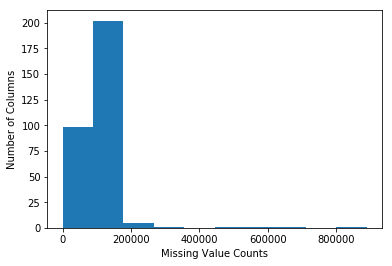

In [77]:
plt.hist(miss_col)
plt.xlabel('Missing Value Counts')
plt.ylabel('Number of Columns')
plt.show()

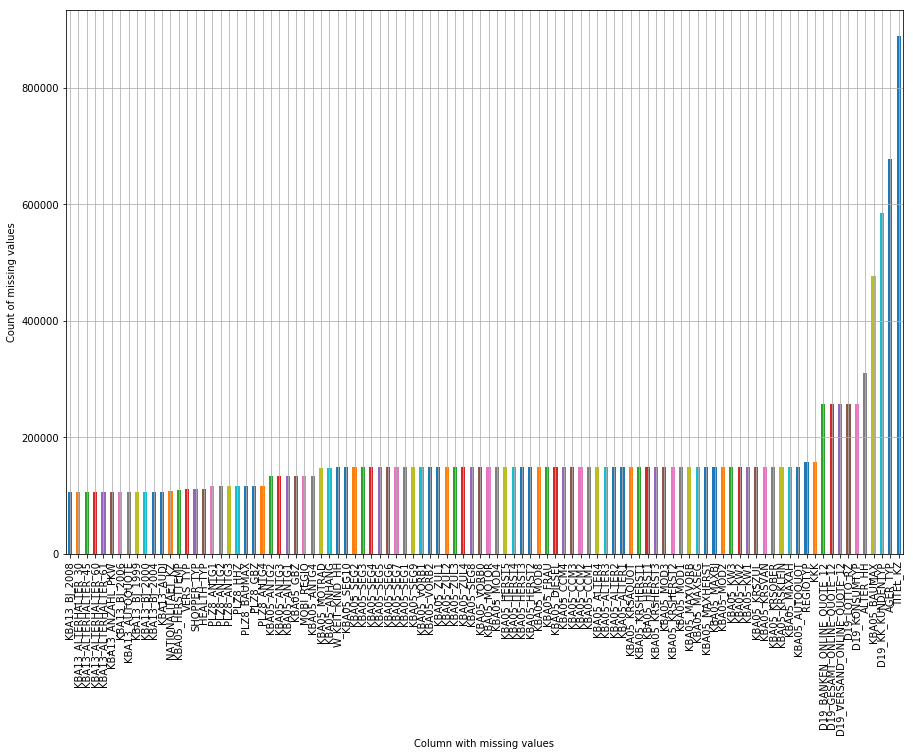

In [78]:
miss_col0 = miss_col[miss_col>0].nlargest(100)
miss_col0.sort_values(inplace=True)
miss_col0.plot.bar(figsize=(15,10))
plt.xlabel('Column with missing values')
plt.ylabel('Count of missing values')
plt.grid(True)
plt.show()

We can see that there is a distinct separation on the top 100 column with missing values at the 200k threshold of missing values. We will drop all of the columns with more than 200k missing values 

In [79]:
miss_col1 = miss_col[miss_col>200000]
azdias4 = azdias3.drop(miss_col1.index, axis=1)
azdias4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 300 entries, ANZ_HAUSHALTE_AKTIV to ALTERSKATEGORIE_GROB
dtypes: float64(240), int64(58), object(2)
memory usage: 2.0+ GB


In [80]:
miss_col1

AGER_TYP                       677503
ALTER_HH                       310267
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_KONSUMTYP                  257113
D19_LOTTO_RZ                   257113
D19_VERSAND_ONLINE_QUOTE_12    257113
KBA05_BAUMAX                   476524
D19_KK_KUNDENTYP               584612
TITEL_KZ                       889061
dtype: int64

In [81]:
feat_info2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
Attribute      2258 non-null object
Description    351 non-null object
Value          2258 non-null object
Meaning        2247 non-null object
dtypes: object(4)
memory usage: 70.6+ KB


In [82]:
feat_info3 = feat_info2[~feat_info2['Attribute'].isin(miss_col1.index)]
feat_info3

,Attribute,Description,Value,Meaning
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years
10,ALTERSKATEGORIE_GROB,NaN,9,uniformly distributed
33,ANREDE_KZ,gender,"-1, 0",unknown
34,ANREDE_KZ,NaN,1,male
35,ANREDE_KZ,NaN,2,female
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)


In [83]:
miss_row = azdias4.isnull().sum(axis=1)

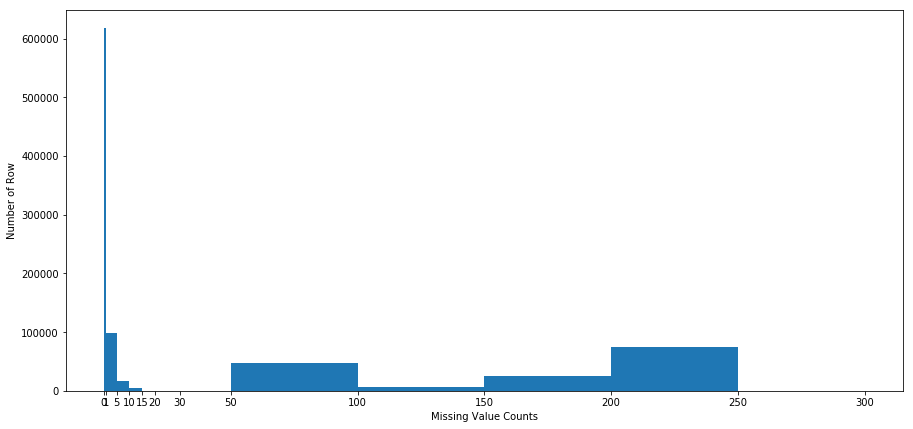

In [84]:
hist_bins = [0,1,5,10,15,20,30,50,100,150,200,250,300]
hist_ticks = np.array([0,1,5,10,15,20,30,50,100,150,200,250,300])
plt.figure(figsize=(15,7))
plt.hist(miss_row,bins=hist_bins)
plt.xticks(hist_ticks,hist_ticks.astype(str))
plt.xlabel('Missing Value Counts')
plt.ylabel('Number of Row')
plt.show()

We can see that there is also a distinct threshold of 15 missing values per row. We decide to drop all of the rows with more than 15 missing values 

In [85]:
miss_row1 = miss_row[miss_row>15]
azdias4 = azdias4.drop(miss_row1, axis=0)
azdias4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891122 entries, 0 to 891220
Columns: 300 entries, ANZ_HAUSHALTE_AKTIV to ALTERSKATEGORIE_GROB
dtypes: float64(240), int64(58), object(2)
memory usage: 2.0+ GB


In [86]:
#azdias4.to_csv("azdias4.csv", header=True)

In [87]:
#feat_info3.to_csv("feat_info3.csv", header=True)

In [2]:
#azdias4 = pd.read_csv("azdias4.csv")
#azdias4 = azdias4.drop(['Unnamed: 0'], axis=1)
#azdias4.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_DEUINTL_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,SOHO_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,11.0,0.0,2.0,0.0,6.0,8A,8.0,51.0,5.0,0,...,1.0,3.0,1.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,10.0,0.0,1.0,0.0,2.0,4C,4.0,24.0,3.0,0,...,4.0,2.0,0.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,1.0,0.0,0.0,0.0,4.0,2A,2.0,12.0,2.0,0,...,4.0,1.0,0.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,3.0,0.0,4.0,0.0,2.0,6B,6.0,43.0,5.0,3,...,7.0,2.0,0.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0


In [3]:
#feat_info3 = pd.read_csv("feat_info3.csv")
#feat_info3 = feat_info3.drop(['Unnamed: 0'], axis=1)
#feat_info3.head()

,Attribute,Description,Value,Meaning
0,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
1,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
2,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
3,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
4,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


### Part 0.4: Categorical Fix 
For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [4]:
categorical = ['ANREDE_KZ', 'BIP_FLAG','CAMEO_DEUG_2015', 'CAMEO_DEU_2015','CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
'D19_KK_KUNDENTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 
'HAUSHALTSSTRUKTUR', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_FLAG', 'VERS_TYP', 'ZABEOTYP']

In [5]:
not_in_az2 = ['HAUSHALTSSTRUKTUR','GEOSCORE_KLS7','WACHSTUMSGEBIET_NB','BIP_FLAG']

In [6]:
miss_column1 = ['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LOTTO_RZ', 'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_BAUMAX', 'D19_KK_KUNDENTYP', 'TITEL_KZ']               

In [7]:
categorical2 = ['ANREDE_KZ','CAMEO_DEUG_2015', 'CAMEO_DEU_2015','CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP', 
                'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'KBA05_HERSTTEMP', 
'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN','LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 
'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 
'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_FLAG', 'VERS_TYP', 'ZABEOTYP']

In [8]:
binary = []
multi = []

for col in categorical2:
    if azdias4[col].nunique() > 2:
        multi.append(col)
    else:
        binary.append(col)
    
        
print('\nBinary categorical variables are : {}'.format(binary))
print('\nMulti-level categorical variables are : {}'.format(multi))


Binary categorical variables are : ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'SOHO_FLAG', 'VERS_TYP']

Multi-level categorical variables are : ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'ZABEOTYP']


In [9]:
for col in binary:
    print(azdias4[col].value_counts())

2.0    465254
1.0    425868
Name: ANREDE_KZ, dtype: int64
0    715917
1    175205
Name: GREEN_AVANTGARDE, dtype: int64
W    629456
O    168535
Name: OST_WEST_KZ, dtype: int64
0.0    810751
1.0      6887
Name: SOHO_FLAG, dtype: int64
2.0    398678
1.0    381267
Name: VERS_TYP, dtype: int64


In [10]:
azdias4['ANREDE_KZ'].replace([2.0,1.0], [1,0], inplace=True)
azdias4['SOHO_FLAG'].replace([1.0,0.0], [1,0], inplace=True)
azdias4['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
azdias4['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)

In [11]:
for col in multi:
    print(azdias4[col].value_counts())

8.0    134432
9.0    108162
6.0    105865
4.0    103904
3.0     86768
2.0     83228
7.0     77920
5.0     55305
1.0     36206
Name: CAMEO_DEUG_2015, dtype: int64
6B    56668
8A    52435
4C    47817
2D    35074
3C    34767
7A    34392
3D    34299
8B    33430
4A    33150
8C    30991
9D    28587
9B    27672
9C    24985
7B    24500
9A    20540
2C    19421
8D    17576
6E    16105
2B    15485
5D    14941
6C    14819
2A    13248
5A    12213
1D    11907
1A    10847
3A    10542
5B    10354
5C     9934
7C     9064
4B     9047
4D     8570
3B     7160
6A     6810
9E     6378
6D     6071
6F     5392
7D     5332
4E     5320
1E     5064
7E     4632
1C     4317
5F     4283
1B     4071
5E     3580
Name: CAMEO_DEU_2015, dtype: int64
51.0    133679
41.0     92322
24.0     91154
14.0     62883
43.0     56668
54.0     45387
25.0     39619
22.0     33150
23.0     26749
13.0     26332
45.0     26129
55.0     23954
52.0     20540
31.0     19023
34.0     18521
15.0     16971
44.0     14819
12.0     13248
35.0 

In [12]:
azdias4['LP_FAMILIE_GROB'].replace([0.0], np.nan, inplace=True)
azdias4['LP_FAMILIE_FEIN'].replace([0.0], np.nan, inplace=True)
azdias4['LP_LEBENSPHASE_FEIN'].replace([0.0], np.nan, inplace=True)
azdias4['LP_LEBENSPHASE_GROB'].replace([0.0], np.nan, inplace=True)

In [14]:
azdias4.loc[azdias4['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'MAINSTREAM'] = 0
azdias4.loc[azdias4['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'MAINSTREAM'] = 1

azdias4.loc[azdias4['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'DECADE'] = 1
azdias4.loc[azdias4['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'DECADE'] = 2
azdias4.loc[azdias4['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'DECADE'] = 3
azdias4.loc[azdias4['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'DECADE'] = 4
azdias4.loc[azdias4['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'DECADE'] = 5
azdias4.loc[azdias4['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'DECADE'] = 6

In [15]:
def wealth(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

    
def lifestage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])

In [17]:
azdias4['WEALTH'] = azdias4['CAMEO_DEUINTL_2015'].apply(wealth)
azdias4['LIFESTAGE'] = azdias4['CAMEO_DEUINTL_2015'].apply(lifestage)

In [18]:
azdias4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891122 entries, 0 to 891121
Columns: 304 entries, ANZ_HAUSHALTE_AKTIV to LIFESTAGE
dtypes: float64(245), int64(58), object(1)
memory usage: 2.0+ GB


In [29]:
azdias5 = azdias4.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1)

We drop the old multi categorical columns that have been reencoded as seperate categorical columns. We also drop the columns that have too specific answers; hnce, many answers for their classification. Some of the columns such as "LP_FAMILIE_GROB" is also discarded due to their indication of household and lifestage already being answered with other columns such as the new columns that we just reencode. 

In [22]:
azdias5.shape

(891122, 298)

In [33]:
#azdias5.to_csv("azdias5.csv", header=True)

In [179]:
#azdias5 = pd.read_csv("azdias5.csv")
#azdias5 = azdias5.drop(['Unnamed: 0'], axis=1)
#azdias5.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,MAINSTREAM,DECADE,WEALTH,LIFESTAGE
0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,10,...,NaN,NaN,NaN,3.0,0.0,2.0,NaN,NaN,NaN,NaN
1,11.0,0.0,2.0,0.0,6.0,8.0,5.0,0,0,10,...,3.0,9.0,4.0,5.0,1.0,1.0,0.0,6.0,5.0,1.0
2,10.0,0.0,1.0,0.0,2.0,4.0,3.0,0,0,10,...,3.0,9.0,2.0,5.0,1.0,3.0,1.0,6.0,2.0,4.0
3,1.0,0.0,0.0,0.0,4.0,2.0,2.0,0,0,10,...,NaN,9.0,7.0,3.0,1.0,4.0,0.0,4.0,1.0,2.0
4,3.0,0.0,4.0,0.0,2.0,6.0,5.0,3,5,5,...,2.0,9.0,3.0,4.0,0.0,3.0,0.0,4.0,4.0,3.0


### Part 0.5: Cleaning Function 

We create the cleaning function so that we can reuse all of these cleaning function again with the customers datasets and train_test datasets as well

In [43]:
feat_info2 = pd.read_csv("feat_info2.csv")
feat_info2 = feat_info2.drop(['Unnamed: 0'], axis=1)
feat_info2.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [292]:
def clean_data(df1,feat_info2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: df1 - Demographics DataFrame
           feat_info2 - Dataframe of features explanation
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # removing and rename columns that does not have description in the feat_info 
    df1 = df1.drop(['LNR','AKT_DAT_KL','ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','ALTERSKATEGORIE_FEIN','ANZ_KINDER','ANZ_STATISTISCHE_HAUSHALTE',
                    'ARBEIT','CJT_KATALOGNUTZER','CJT_TYP_1','CJT_TYP_2','CJT_TYP_3','CJT_TYP_4','CJT_TYP_5','CJT_TYP_6','D19_KONSUMTYP_MAX','D19_LETZTER_KAUF_BRANCHE',
                    'D19_SOZIALES','D19_TELKO_ONLINE_QUOTE_12','D19_VERSI_DATUM','D19_VERSI_OFFLINE_DATUM','D19_VERSI_ONLINE_DATUM','D19_VERSI_ONLINE_QUOTE_12',
                    'DSL_FLAG','EINGEFUEGT_AM','EINGEZOGENAM_HH_JAHR','EXTSEL992','FIRMENDICHTE','GEMEINDETYP','HH_DELTA_FLAG','KBA13_ANTG1',
                    'KBA13_ANTG2','KBA13_ANTG3','KBA13_ANTG4','KBA13_BAUMAX','KBA13_GBZ','KBA13_HHZ','KBA13_KMH_210','KOMBIALTER','KONSUMZELLE',
                    'MOBI_RASTER','RT_KEIN_ANREIZ','RT_SCHNAEPPCHEN','RT_UEBERGROESSE','STRUKTURTYP','UMFELD_ALT','UMFELD_JUNG','UNGLEICHENN_FLAG',
                    'VERDICHTUNGSRAUM','VHA','VHN','VK_DHT4A','VK_DISTANZ','VK_ZG11'], axis=1)
    
    df1 = df1.rename(columns = {'CAMEO_INTL_2015':'CAMEO_DEUINTL_2015', 'D19_KOSMETIK': 'D19_KOSMETIK_RZ', 'D19_BANKEN_LOKAL': 'D19_BANKEN_LOKAL_RZ',
                                'D19_BANKEN_REST':'D19_BANKEN_REST_RZ', 'D19_BANKEN_GROSS':'D19_BANKEN_GROSS_RZ', 'D19_BEKLEIDUNG_GEH': 'D19_BEKLEIDUNG_GEH_RZ',
                                'D19_BANKEN_DIREKT':'D19_BANKEN_DIREKT_RZ', 'D19_BEKLEIDUNG_REST': 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG': 'D19_BILDUNG_RZ',
                                'D19_BIO_OEKO':'D19_BIO_OEKO_RZ', 'D19_BUCH_CD':'D19_BUCH_RZ', 'D19_DIGIT_SERV':'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL':'D19_DROGERIEARTIKEL_RZ',
                                'D19_ENERGIE': 'D19_ENERGIE_RZ', 'D19_FREIZEIT':'D19_FREIZEIT_RZ', 'D19_GARTEN':'D19_GARTEN_RZ', 'D19_HANDWERK': 'D19_HANDWERK_RZ', 
                                'D19_HAUS_DEKO':'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL':'D19_KINDERARTIKEL_RZ', 'D19_LEBENSMITTEL': 'D19_LEBENSMITTEL_RZ', 
                                'D19_NAHRUNGSERGAENZUNG':'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER':'D19_RATGEBER_RZ', 'D19_REISEN': 'D19_REISEN_RZ', 
                                'D19_SAMMELARTIKEL':'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE': 'D19_SCHUHE_RZ', 'D19_TELKO_REST': 'D19_TELKO_REST_RZ',  
                                'D19_SONSTIGE':'D19_SONSTIGE_RZ', 'D19_TELKO_MOBILE': 'D19_TELKO_MOBILE_RZ', 'D19_TECHNIK': 'D19_TECHNIK_RZ',
                                'D19_VOLLSORTIMENT': 'D19_VOLLSORTIMENT_RZ', 'D19_TIERARTIKEL':'D19_TIERARTIKEL_RZ', 'D19_VERSICHERUNGEN': 'D19_VERSICHERUNGEN_RZ',
                                'SOHO_KZ':'SOHO_FLAG', 'KBA13_CCM_1401_2500': 'KBA13_CCM_1400_2500', 'D19_VERSAND_REST':'D19_VERSAND_REST_RZ', 
                                'D19_WEIN_FEINKOST':'D19_WEIN_FEINKOST_RZ', 'D19_LOTTO': 'D19_LOTTO_RZ', 'KK_KUNDENTYP': 'D19_KK_KUNDENTYP'})
    
    # convert missing value codes into NaNs
    df1['CAMEO_DEUG_2015'].replace(['X'], np.nan, inplace=True)
    df1['CAMEO_DEU_2015'].replace(['XX'], np.nan, inplace=True)
    df1['CAMEO_DEUINTL_2015'].replace(['XX'], np.nan, inplace=True)
    
    feat_nan = feat_info2[feat_info2['Meaning'].str.contains('unknown', na=False)]
    
    nan = []

    for attribute in feat_nan['Attribute'].unique():
        val = feat_nan.loc[feat_nan['Attribute'] == attribute, 
                                        'Value'].astype(str).str.cat(sep=',').split(',')
        nan.append(val)

    feat_nan = pd.concat([pd.Series(feat_nan['Attribute'].unique()), pd.Series(nan)], axis=1)
    feat_nan.columns = ['Attribute', 'missing_or_unknown']
    
    for row in feat_nan['Attribute']:
        print(row)
        if row in df1.columns:
            na_map = feat_nan.loc[feat_nan['Attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = df1.loc[:, row].isin(na_map)
            df1.loc[na_idx, row] = np.NaN
        else:
            continue
        
    # Removing column and rows witn high amount of NaNs
    miss_col1 = ['AGER_TYP','ALTER_HH','D19_BANKEN_ONLINE_QUOTE_12','D19_GESAMT_ONLINE_QUOTE_12','D19_KK_KUNDENTYP','D19_KONSUMTYP',
                 'D19_LOTTO_RZ','D19_VERSAND_ONLINE_QUOTE_12','KBA05_BAUMAX','TITEL_KZ']
    df1 = df1.drop(miss_col1, axis=1)
    
    row_na = df1.shape[1] - df1.count(axis = 1)
    rows_to_drop = df1.index[row_na > 15]
    df1.drop(rows_to_drop, axis=0, inplace = True)
    
    # Fixing categorical and mixed features
    df1['ANREDE_KZ'].replace([2.0,1.0], [1,0], inplace=True)
    df1['SOHO_FLAG'].replace([1.0,0.0], [1,0], inplace=True)
    df1['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    df1['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'MAINSTREAM'] = 0
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'MAINSTREAM'] = 1

    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'DECADE'] = 1
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'DECADE'] = 2
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'DECADE'] = 3
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'DECADE'] = 4
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'DECADE'] = 5
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'DECADE'] = 6
    
    def wealth(x):
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[0])

    
    def lifestage(x):
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[1])
    
    df1['WEALTH'] = df1['CAMEO_DEUINTL_2015'].apply(wealth)
    df1['LIFESTAGE'] = df1['CAMEO_DEUINTL_2015'].apply(lifestage)
    
    df1 = df1.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_DEU_2015','CAMEO_DEUINTL_2015', 'LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1)
    
    
    # Return the cleaned dataframe.
    return df1

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Part 1.1: Imputing, Dummy and Feature Scaling 
- In order to perform the analysis properly, we neeed to deal with all of the NaN since sklearn requires that data not have missing values in order for its estimators to work properly which is why we will use imputer to fill all of the missing values with the mode of the column (better with categorical variable) 
- Then, we will perform the OneHotEncoding toward the categorical variable with more than 2 answers (multi) 
- Finally, we will use StandardScaler() for the feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In [224]:
azdias5.shape

(891122, 297)

In [180]:
fill_nan = Imputer(strategy='most_frequent')
azdias6 = pd.DataFrame(fill_nan.fit_transform(azdias5))

C:\Users\Audi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [181]:
azdias6.columns = azdias5.columns
azdias6.index = azdias5.index

In [182]:
multi2 = ['CAMEO_DEUG_2015', 'CJT_GESAMTTYP','DECADE', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LIFESTAGE', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'WEALTH', 'ZABEOTYP']

In [183]:
for col in multi2:
    dummy = pd.get_dummies(azdias6[col], prefix = col)
    azdias6 = pd.concat([azdias6, dummy], axis = 1)

azdias7 = azdias6.drop(multi2, axis=1)

In [184]:
scaler = StandardScaler() 
azdias8 = scaler.fit_transform(azdias7)

C:\Users\Audi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Audi\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [185]:
azdias8 = pd.DataFrame(azdias8, columns=list(azdias7))

### Part 1.2: PCA & Interpretation
After scaling our data, we will perform the dimensionality reduction by using the principal component analysis. First, we will use PCA with full components in order to find the maximal variance of the data. Then, we will reduced the amount of components expecially the one that does not effect the variances heavily. 

In [187]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias8)

In [188]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

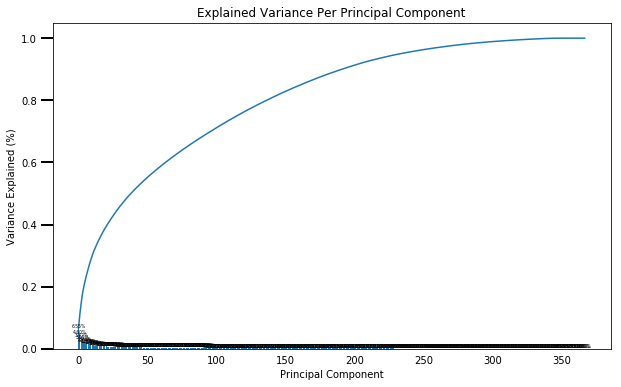

In [189]:
scree_plot(pca)

In [190]:
pca.explained_variance_ratio_.sum()

0.9999999999999998

In [191]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=200)
azdias_pca = pca.fit_transform(azdias8)

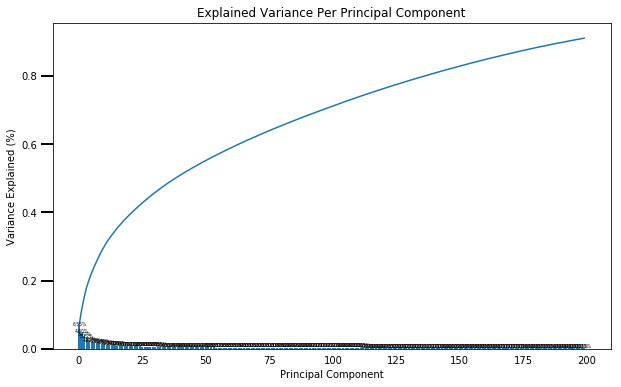

In [192]:
scree_plot(pca)

In [193]:
pca.explained_variance_ratio_.sum()

0.9102588016836745

As for PCA, there is no certain methods other than [elbow](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) which is also not reliable; however, I decided to keep the nearest round of principal components used which can explain around 90% variability 

In [204]:
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias8.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [205]:
pca_weight_0 = pca_weights(pca, 0)
pca_weight_0.nlargest(10)

MOBI_REGIO           0.137309
KBA05_ANTG1          0.133588
PLZ8_ANTG1           0.133180
LP_STATUS_GROB       0.133015
LP_STATUS_FEIN       0.130466
KBA05_GBZ            0.124626
KBA05_AUTOQUOT       0.124235
D19_GESAMT_ANZ_24    0.111139
KBA13_AUTOQUOTE      0.108386
FINANZ_MINIMALIST    0.107260
Name: 0, dtype: float64

In [206]:
pca_weight_0.nsmallest(10)

PLZ8_ANTG3                -0.130994
WEALTH_5.0                -0.124603
D19_GESAMT_DATUM          -0.112868
LIFESTAGE_1.0             -0.108914
D19_VERSAND_DATUM         -0.108200
PLZ8_BAUMAX               -0.106196
FINANZ_HAUSBAUER          -0.104996
D19_GESAMT_ONLINE_DATUM   -0.104824
HH_EINKOMMEN_SCORE        -0.104340
EWDICHTE                  -0.103820
Name: 0, dtype: float64

In [207]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_1 = pca_weights(pca, 1)
pca_weight_1.nlargest(10)

KBA13_HERST_BMW_BENZ           0.178928
KBA13_SEG_OBEREMITTELKLASSE    0.154356
KBA13_MERCEDES                 0.152568
KBA13_BMW                      0.149000
KBA13_SITZE_4                  0.141673
KBA13_SEG_SPORTWAGEN           0.137469
KBA13_KMH_211                  0.125543
KBA05_HERST1                   0.123404
KBA13_KMH_250                  0.123286
KBA13_KW_121                   0.122664
Name: 1, dtype: float64

In [208]:
pca_weight_1.nsmallest(10)

KBA13_SITZE_5             -0.144005
KBA13_KMH_140_210         -0.129763
KBA13_SEG_KLEINWAGEN      -0.128678
KBA13_HALTER_25           -0.115610
KBA13_KMH_180             -0.114340
KBA13_HALTER_20           -0.113723
KBA13_SEG_KOMPAKTKLASSE   -0.106890
KBA13_HERST_FORD_OPEL     -0.105513
KBA13_ALTERHALTER_60      -0.103353
KBA13_KW_0_60             -0.101353
Name: 1, dtype: float64

In [209]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_2 = pca_weights(pca, 2)
pca_weight_2.nlargest(10)

D19_GESAMT_ANZ_24      0.165203
D19_GESAMT_ANZ_12      0.156239
D19_VERSAND_ANZ_24     0.151377
ONLINE_AFFINITAET      0.145144
D19_VERSAND_ANZ_12     0.139805
PLZ8_ANTG4             0.128377
PLZ8_BAUMAX            0.124868
ORTSGR_KLS9            0.112937
D19_BANKEN_ANZ_24      0.102952
D19_VERSAND_REST_RZ    0.102586
Name: 2, dtype: float64

In [210]:
pca_weight_2.nsmallest(10)

D19_GESAMT_ONLINE_DATUM    -0.159621
D19_GESAMT_DATUM           -0.156942
D19_VERSAND_ONLINE_DATUM   -0.152808
D19_VERSAND_DATUM          -0.151794
ZABEOTYP_3.0               -0.126554
D19_BANKEN_DATUM           -0.123001
KBA13_AUTOQUOTE            -0.112267
D19_BANKEN_ONLINE_DATUM    -0.110924
KBA13_ALTERHALTER_60       -0.108474
D19_TELKO_DATUM            -0.108028
Name: 2, dtype: float64

### Discussion 1.2: Interpret Principal Components¶

Answer: We will disclose the relationship of top three positive and negative components of each principal components

1. PCA0

MOBI_REGIO, PLZ8_ANTG1, KBA05_ANTG1 are the top three positively correlated components that affect the first principal components. This indicates that low mobility, high number of 1-2 family houses in area PLZ8 and KBA05 is associated with these principal components.
PLZ8_ANTG3 , D19_GESAMT_DATUM and WEALTH_5.0  are the top three negatively correlated components. This indicates that high number of 6-10 family houses in area PLZ8, no actuality of the last transaction with the complete file and poor wealth.
This principal compenent measures the number of shares of houses in the indicated areas especially PLZ8 as well as their mobility and number of transactions of certain products which both positive and negative results complement each other. 

2. PCA1

KBA13_HERST_BMW_BENZ, KBA13_SEG_OBEREMITTELKLASSE and KBA13_MERCEDES are the top three positively correlated components for our 2nd PCA. this indicates the high share of BMW & Mercedes Benz (upper middle and upper class cars) within the PLZ8.
KBA13_SITZE_5, KBA13_KMH_140_210 and KBA13_SEG_KLEINWAGEN  are the top three negatively correlated components for this principal component. this indicates that the low number of car with 5 seats, max speed between 140-210 km/h as well as low share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8.
This principal component measures based on the car class especially the high class one which associated with lower seats and higher max speed as well as some certain high-brand class appereances. 

3. PCA2

D19_GESAMT_ANZ_24, D19_GESAMT_ANZ_12 and D19_VERSAND_ANZ_24 are the top three positively correlated components for our last PCA. this indicates that there has been high activities of transaction of all products in the last 1-2 years especially through mail order. 
D19_GESAMT_ONLINE_DATUM, D19_GESAMT_DATUM and D19_VERSAND_ONLINE_DATUM are the top three negatively correlated components for this PCA. this indicates no actuality of both online transaction and transaction with items(complete file and segemnted mail).
This principal components measures the effectiveness of the mail order and the ineffectiveness of online transaction for high volume of transactions. 

### Part 1.3: Clustering
In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep. Once we selected a final number of clusters to use, we will re-fit a KMeans instance to perform the clustering operation

In [211]:
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters = center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [212]:
scores = []
centers = list(range(2,30,2))

for center in centers:
    score = round(get_kmeans_score(azdias_pca, center))
    print('center : {}     score : {}'.format(center, score))
    scores.append(score)

center : 2     score : 283013460.0
center : 4     score : 269281194.0
center : 6     score : 259572426.0
center : 8     score : 254509781.0
center : 10     score : 250992190.0
center : 12     score : 247737010.0
center : 14     score : 245607284.0
center : 16     score : 243844068.0
center : 18     score : 242234997.0
center : 20     score : 240894913.0
center : 22     score : 239629893.0
center : 24     score : 238182109.0
center : 26     score : 236807571.0
center : 28     score : 236255391.0


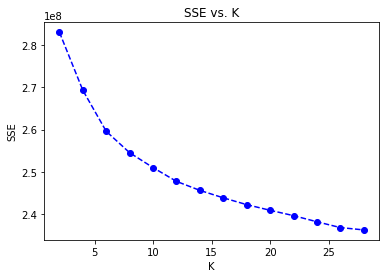

In [213]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K'); 

In [323]:
kmeans_10 = KMeans(n_clusters = 10)
model_10 = kmeans_10.fit(azdias_pca)
azdias_pred = model_10.predict(azdias_pca)

### Part 1.4: Cleaning, Imputing and Feature Scaling Customers 

In this part, we will perform all of the steps that had been done on the general population toward the customers data. We are going to use the fits from the general population to clean, transform, and cluster the customer data. Then, we will interpret how the general population fits apply to the customer data.

In [ ]:
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [215]:
customers = pd.read_csv("customers.csv")
customers = customers.drop(['Unnamed: 0'], axis=1)
customers.head()

C:\Users\Audi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [216]:
customers = customers.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP','ONLINE_PURCHASE'], axis=1)

In [293]:
customers_clean = clean_data(customers, feat_info2)

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_KK_KUNDENTYP
EWDICHTE
FINANZTYP
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
HEALTH_TYP
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_AUTOQUOT
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA05_DIESEL
KBA05_FRAU
KBA05_GBZ
KBA05_HERST1
KBA05_HERST2
KBA05_HERST3
KBA05_HERST4
KBA05_HERST5
KBA05_HERSTTEMP
KBA05_KRSAQUOT
KBA05_KRSHERST1
KBA05_KRSHERST2
KBA05_KRSHERST3
KBA05_KRSKLEIN
KBA05_KRSOBER
KBA05_KRSVAN
KBA05_KRSZUL
KBA05_KW1
KBA05_KW2
KBA05_KW3
KBA05_MAXAH
KBA05_MAXBJ
KBA05_MAXHERST
KBA05_MAXSEG
KBA05_MAXVORB
KBA05_MOD1
KBA05_MOD2
KBA05_MOD3
KBA05_MOD4
KBA05_MOD8
KBA05_MODTEMP
KBA05_MOTOR
KBA05_MOTRAD
KBA05_SEG1
KBA05_SEG10
KBA05_SEG2
KBA05_SEG3
KBA05_S

In [248]:
customers_clean.shape

(133960, 297)

In [245]:
azdias6.shape

(891122, 382)

In [294]:
customers_imputer = pd.DataFrame(fill_nan.transform(customers_clean))
customers_imputer.columns = customers_clean.columns
customers_imputer.index = customers_clean.index

In [295]:
for col in multi2:
    dummy = pd.get_dummies(customers_imputer[col], prefix = col)
    customers_imputer = pd.concat([customers_imputer, dummy], axis = 1)

customers_dummy = customers_imputer.drop(multi2, axis=1)

In [296]:
list_as = list(azdias7.columns) 

In [297]:
list_dum = list(customers_dummy.columns) 

In [239]:
def setdiff_sorted(array1,array2,assume_unique=False):
    ans = np.setdiff1d(array1,array2,assume_unique).tolist()
    if assume_unique:
        return sorted(ans)
    return ans

In [298]:
main_list = setdiff_sorted(list_as,list_dum)
main_list

['GEBAEUDETYP_5.0']

In [299]:
customers_dummy['GEBAEUDETYP_5.0'] = 0

In [300]:
customers_dummy['GEBAEUDETYP_5.0'].value_counts()

0    134230
Name: GEBAEUDETYP_5.0, dtype: int64

In [301]:
customers_scaler = scaler.transform(customers_dummy)
customers_scaler = pd.DataFrame(customers_scaler, columns=list(customers_dummy))

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [324]:
customers_pca = pca.fit_transform(customers_scaler)

In [325]:
customers_pred = model_10.predict(customers_pca)

### Part 1.5: Comparing the Customer Data to Demographics Data
At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Text(0.5, 1.0, 'General Clusters')

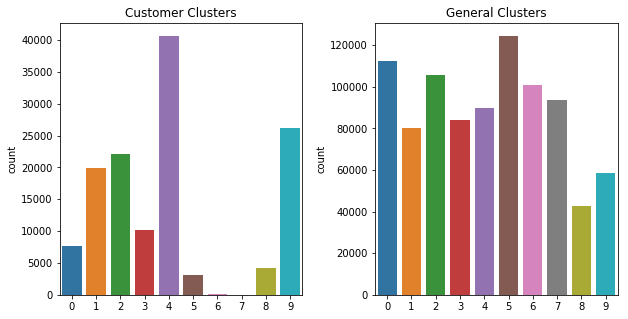

In [326]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = .5, wspace=.3)

sb.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sb.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')

In [327]:
cust_df = pd.DataFrame(customers_pred,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(customers_pred)*100
gen_df = pd.DataFrame(azdias_pred,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(azdias_pred)*100
diff = (cust_df-gen_df)
diff.rename_axis({'index':'DiffPerc'}, axis=1, inplace=True)
cust_df.rename_axis({'index':'CustPerc'}, axis=1, inplace=True)
gen_df.rename_axis({'index':'GenPerc'}, axis=1, inplace=True)
diff = diff.join(cust_df).join(gen_df).sort_values('DiffPerc',ascending=False)
diff.fillna(0, inplace=True)
diff

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  after removing the cwd from sys.path.
C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  """
C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  


,DiffPerc,CustPerc,GenPerc
Cluster,,,
4,20.233886,30.284586,10.050700
9,12.943727,19.492662,6.548935
1,5.915688,14.892349,8.976661
2,4.661710,16.489607,11.827898
8,-1.665257,3.119273,4.784530
3,-1.868368,7.578038,9.446406
0,-6.901424,5.682038,12.583462
7,-10.474236,0.014900,10.489136
6,-11.228677,0.103554,11.332231


In [343]:
centroid_4 = pca.inverse_transform(model_10.cluster_centers_[4])

In [344]:
over = pd.Series(data = centroid_4, index = customers_scaler.columns).sort_values()
over

NATIONALITAET_KZ_2.0        -2.757406
GEBAEUDETYP_6.0             -2.648096
FINANZ_ANLEGER              -0.981687
KBA13_SITZE_5               -0.930522
KBA13_KMH_140_210           -0.914502
KBA05_MAXHERST_3.0          -0.900528
FINANZ_SPARER               -0.879336
D19_VERSAND_OFFLINE_DATUM   -0.843655
KBA13_HERST_FORD_OPEL       -0.833209
HH_EINKOMMEN_SCORE          -0.821263
D19_GESAMT_OFFLINE_DATUM    -0.800123
KBA13_HALTER_25             -0.797107
KKK                         -0.793002
KBA13_KRSHERST_FORD_OPEL    -0.734055
D19_GESAMT_DATUM            -0.725692
KBA13_ALTERHALTER_30        -0.721692
KBA05_HERST3                -0.721563
KBA13_HERST_ASIEN           -0.719179
REGIOTYP                    -0.705091
KBA13_SEG_KLEINWAGEN        -0.705040
SEMIO_KAEM                  -0.693500
D19_VERSAND_DATUM           -0.676085
KBA13_FORD                  -0.671157
DECADE_6.0                  -0.658452
SEMIO_KRIT                  -0.643683
KBA13_OPEL                  -0.640918
KBA05_KRSHER

In [345]:
centroid_5 = pca.inverse_transform(model_10.cluster_centers_[5])

In [346]:
under = pd.Series(data = centroid_5, index = customers_scaler.columns).sort_values()
under

NATIONALITAET_KZ_2.0        -2.794348
HH_EINKOMMEN_SCORE          -1.260970
FINANZ_SPARER               -1.071816
FINANZ_ANLEGER              -1.070870
LIFESTAGE_1.0               -0.939768
SEMIO_PFLICHT               -0.802075
SEMIO_RAT                   -0.795880
SEMIO_KAEM                  -0.795160
REGIOTYP                    -0.757822
DECADE_6.0                  -0.728577
SEMIO_KRIT                  -0.717241
ZABEOTYP_4.0                -0.711287
KKK                         -0.686730
D19_VERSAND_OFFLINE_DATUM   -0.672134
KBA05_KW1                   -0.668340
CAMEO_DEUG_2015_8.0         -0.666516
FINANZ_HAUSBAUER            -0.665997
KBA05_VORB2                 -0.661354
FINANZ_UNAUFFAELLIGER       -0.657530
PLZ8_ANTG3                  -0.656044
SHOPPER_TYP_2.0             -0.647947
ANREDE_KZ                   -0.647872
KBA05_MAXHERST_3.0          -0.631662
KBA13_ALTERHALTER_30        -0.629393
KBA13_BJ_2000               -0.615407
KBA13_HALTER_30             -0.609326
D19_GESAMT_O

### Discussion 1.5: Compare Customer Data to Demographics Data

If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data suggests that group of persons to be outside of the target demographics.

**Answer:** 

From the list we can see that the most overrepresented cluster is cluster 4 and the most underrepresented culster is cluster 5. The charateristics of cluster 4 are: 
- Pre-Family Couples & Singles
- Most likely German nationality (prename analysis)
- Owned VW-Audi
- High chance to be an investor 
- Reside in mixed building (unknown whether residential or commercial)

While the charateristics of cluster 5 are: 
- Reside in mixed building (unknown whether residential or commercial)
- Most likely German nationality (prename analysis)
- Fair supplied energy consumer
- High money saving tendency  
- High income 


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Part 2.1: Cleaning, Imputing and Scaling 

In [ ]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [102]:
mailout_train = pd.read_csv("mailout_train.csv")
mailout_train = mailout_train.drop(['Unnamed: 0'], axis=1)
mailout_train.head()

C:\Users\Audi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [332]:
mailout_train2 = clean_data(mailout_train, feat_info2)

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_KK_KUNDENTYP
EWDICHTE
FINANZTYP
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
HEALTH_TYP
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_AUTOQUOT
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA05_DIESEL
KBA05_FRAU
KBA05_GBZ
KBA05_HERST1
KBA05_HERST2
KBA05_HERST3
KBA05_HERST4
KBA05_HERST5
KBA05_HERSTTEMP
KBA05_KRSAQUOT
KBA05_KRSHERST1
KBA05_KRSHERST2
KBA05_KRSHERST3
KBA05_KRSKLEIN
KBA05_KRSOBER
KBA05_KRSVAN
KBA05_KRSZUL
KBA05_KW1
KBA05_KW2
KBA05_KW3
KBA05_MAXAH
KBA05_MAXBJ
KBA05_MAXHERST
KBA05_MAXSEG
KBA05_MAXVORB
KBA05_MOD1
KBA05_MOD2
KBA05_MOD3
KBA05_MOD4
KBA05_MOD8
KBA05_MODTEMP
KBA05_MOTOR
KBA05_MOTRAD
KBA05_SEG1
KBA05_SEG10
KBA05_SEG2
KBA05_SEG3
KBA05_S

In [333]:
mailout_train2['RESPONSE']

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
11       0
12       0
13       0
14       0
15       0
17       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
28       0
29       0
30       0
31       0
32       0
34       0
35       0
36       0
        ..
42930    0
42931    0
42932    0
42933    0
42934    0
42935    1
42936    0
42937    0
42938    0
42939    0
42940    0
42941    0
42942    0
42943    0
42944    0
42945    0
42946    0
42947    0
42948    0
42949    0
42950    0
42951    0
42952    0
42953    0
42955    0
42956    0
42957    0
42959    0
42960    0
42961    0
Name: RESPONSE, Length: 33836, dtype: int64

In [334]:
Ytr = mailout_train2['RESPONSE']
Xtr= mailout_train2.drop(['RESPONSE'], axis=1)

In [335]:
Xtr_imputer = pd.DataFrame(fill_nan.fit_transform(Xtr))
Xtr_imputer.columns = Xtr.columns
Xtr_imputer.index = Xtr.index

In [336]:
for col in multi2:
    dummy = pd.get_dummies(Xtr_imputer[col], prefix = col)
    Xtr_imputer = pd.concat([Xtr_imputer, dummy], axis = 1)

Xtr_imputer = Xtr_imputer.drop(multi2, axis=1)

In [337]:
Xtr_scaler = scaler.fit_transform(Xtr_imputer)
Xtr_scaler = pd.DataFrame(Xtr_scaler, columns=list(Xtr_imputer))

C:\Users\Audi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Audi\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Part 2.2: Comparing models and algorithms 

In [370]:
clf_A = LogisticRegression(random_state=135)
clf_B = RandomForestClassifier(random_state=135)
clf_C = AdaBoostClassifier(random_state=135)
clf_D = GradientBoostingClassifier(random_state=135)

In [356]:
def classifier_roc(clf, param_grid, X=Xtr_scaler, y=Ytr):
    """
    Fit a classifier using GridSearchCV and calculates ROC AUC
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - Xtr_scaler (DataFrame): features of the training dataframe
    - Ytr (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - prints elapsed time and ROX AUC
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', verbose = 3, n_jobs=10, cv=5)
    grid.fit(X, y)
    

    print(grid.best_score_)
    
    return grid.best_estimator_

In [371]:
print(classifier_roc(clf_A, {}))
print(classifier_roc(clf_B, {}))
print(classifier_roc(clf_C, {}))
print(classifier_roc(clf_D, {}))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   12.2s remaining:   18.4s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   12.9s finished
C:\Users\Audi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.57305759766727
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=135, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    1.9s finished
C:\Users\Audi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5006232999997577
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=135, verbose=0, warm_start=False)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.8s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    7.4s finished


0.5535341784721199
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=135)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   26.8s remaining:   40.2s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   27.6s finished


0.5573311270230125
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=135,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


|     Model      |     ROC_AUC       |
| :------------: | :---------------: | 
| Logistic       |     0.5731        |  
| RandomForest   |     0.5006        | 
| Adaboost       |     0.5535        |  
| GradientBoost  |     0.5573        | 

We choose Logistic Regression because it has the best ROC_AUC results 

### Part 2.3: Optimizing Model 

In [385]:
param_grid = {'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
              'penalty': ['l2']}

grid = GridSearchCV(estimator=LogisticRegression(random_state=135), param_grid=param_grid, scoring='roc_auc', 
                    verbose = 3, n_jobs=10, cv=5)

grid.fit(Xtr_scaler, Ytr)
print(grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  35 out of  40 | elapsed:   26.3s remaining:    3.7s
[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:   32.0s finished
C:\Users\Audi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5843517023686311
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=135, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


By giving the C parameters more range, we can increase the roc_auc score from 0.5731 to 0.5843

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### Part 3.1: Cleaning, Imputing and Scaling 

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [373]:
mailout_test = pd.read_csv('mailout_test.csv')
mailout_test = mailout_test.drop(['Unnamed: 0'], axis=1)
mailout_test.head()

C:\Users\Audi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [376]:
def clean_data2(df1,feat_info2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: df1 - Demographics DataFrame
           feat_info2 - Dataframe of features explanation
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # removing and rename columns that does not have description in the feat_info (LNR needed)
    df1 = df1.drop(['AKT_DAT_KL','ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','ALTERSKATEGORIE_FEIN','ANZ_KINDER','ANZ_STATISTISCHE_HAUSHALTE',
                    'ARBEIT','CJT_KATALOGNUTZER','CJT_TYP_1','CJT_TYP_2','CJT_TYP_3','CJT_TYP_4','CJT_TYP_5','CJT_TYP_6','D19_KONSUMTYP_MAX','D19_LETZTER_KAUF_BRANCHE',
                    'D19_SOZIALES','D19_TELKO_ONLINE_QUOTE_12','D19_VERSI_DATUM','D19_VERSI_OFFLINE_DATUM','D19_VERSI_ONLINE_DATUM','D19_VERSI_ONLINE_QUOTE_12',
                    'DSL_FLAG','EINGEFUEGT_AM','EINGEZOGENAM_HH_JAHR','EXTSEL992','FIRMENDICHTE','GEMEINDETYP','HH_DELTA_FLAG','KBA13_ANTG1',
                    'KBA13_ANTG2','KBA13_ANTG3','KBA13_ANTG4','KBA13_BAUMAX','KBA13_GBZ','KBA13_HHZ','KBA13_KMH_210','KOMBIALTER','KONSUMZELLE',
                    'MOBI_RASTER','RT_KEIN_ANREIZ','RT_SCHNAEPPCHEN','RT_UEBERGROESSE','STRUKTURTYP','UMFELD_ALT','UMFELD_JUNG','UNGLEICHENN_FLAG',
                    'VERDICHTUNGSRAUM','VHA','VHN','VK_DHT4A','VK_DISTANZ','VK_ZG11'], axis=1)
    
    df1 = df1.rename(columns = {'CAMEO_INTL_2015':'CAMEO_DEUINTL_2015', 'D19_KOSMETIK': 'D19_KOSMETIK_RZ', 'D19_BANKEN_LOKAL': 'D19_BANKEN_LOKAL_RZ',
                                'D19_BANKEN_REST':'D19_BANKEN_REST_RZ', 'D19_BANKEN_GROSS':'D19_BANKEN_GROSS_RZ', 'D19_BEKLEIDUNG_GEH': 'D19_BEKLEIDUNG_GEH_RZ',
                                'D19_BANKEN_DIREKT':'D19_BANKEN_DIREKT_RZ', 'D19_BEKLEIDUNG_REST': 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG': 'D19_BILDUNG_RZ',
                                'D19_BIO_OEKO':'D19_BIO_OEKO_RZ', 'D19_BUCH_CD':'D19_BUCH_RZ', 'D19_DIGIT_SERV':'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL':'D19_DROGERIEARTIKEL_RZ',
                                'D19_ENERGIE': 'D19_ENERGIE_RZ', 'D19_FREIZEIT':'D19_FREIZEIT_RZ', 'D19_GARTEN':'D19_GARTEN_RZ', 'D19_HANDWERK': 'D19_HANDWERK_RZ', 
                                'D19_HAUS_DEKO':'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL':'D19_KINDERARTIKEL_RZ', 'D19_LEBENSMITTEL': 'D19_LEBENSMITTEL_RZ', 
                                'D19_NAHRUNGSERGAENZUNG':'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER':'D19_RATGEBER_RZ', 'D19_REISEN': 'D19_REISEN_RZ', 
                                'D19_SAMMELARTIKEL':'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE': 'D19_SCHUHE_RZ', 'D19_TELKO_REST': 'D19_TELKO_REST_RZ',  
                                'D19_SONSTIGE':'D19_SONSTIGE_RZ', 'D19_TELKO_MOBILE': 'D19_TELKO_MOBILE_RZ', 'D19_TECHNIK': 'D19_TECHNIK_RZ',
                                'D19_VOLLSORTIMENT': 'D19_VOLLSORTIMENT_RZ', 'D19_TIERARTIKEL':'D19_TIERARTIKEL_RZ', 'D19_VERSICHERUNGEN': 'D19_VERSICHERUNGEN_RZ',
                                'SOHO_KZ':'SOHO_FLAG', 'KBA13_CCM_1401_2500': 'KBA13_CCM_1400_2500', 'D19_VERSAND_REST':'D19_VERSAND_REST_RZ', 
                                'D19_WEIN_FEINKOST':'D19_WEIN_FEINKOST_RZ', 'D19_LOTTO': 'D19_LOTTO_RZ', 'KK_KUNDENTYP': 'D19_KK_KUNDENTYP'})
    
    # convert missing value codes into NaNs
    df1['CAMEO_DEUG_2015'].replace(['X'], np.nan, inplace=True)
    df1['CAMEO_DEU_2015'].replace(['XX'], np.nan, inplace=True)
    df1['CAMEO_DEUINTL_2015'].replace(['XX'], np.nan, inplace=True)
    
    feat_nan = feat_info2[feat_info2['Meaning'].str.contains('unknown', na=False)]
    
    nan = []

    for attribute in feat_nan['Attribute'].unique():
        val = feat_nan.loc[feat_nan['Attribute'] == attribute, 
                                        'Value'].astype(str).str.cat(sep=',').split(',')
        nan.append(val)

    feat_nan = pd.concat([pd.Series(feat_nan['Attribute'].unique()), pd.Series(nan)], axis=1)
    feat_nan.columns = ['Attribute', 'missing_or_unknown']
    
    for row in feat_nan['Attribute']:
        print(row)
        if row in df1.columns:
            na_map = feat_nan.loc[feat_nan['Attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = df1.loc[:, row].isin(na_map)
            df1.loc[na_idx, row] = np.NaN
        else:
            continue
        
    # Removing column ONLY with high amount of NaNs
    miss_col1 = ['AGER_TYP','ALTER_HH','D19_BANKEN_ONLINE_QUOTE_12','D19_GESAMT_ONLINE_QUOTE_12','D19_KK_KUNDENTYP','D19_KONSUMTYP',
                 'D19_LOTTO_RZ','D19_VERSAND_ONLINE_QUOTE_12','KBA05_BAUMAX','TITEL_KZ']
    df1 = df1.drop(miss_col1, axis=1)
    
    # Fixing categorical and mixed features
    df1['ANREDE_KZ'].replace([2.0,1.0], [1,0], inplace=True)
    df1['SOHO_FLAG'].replace([1.0,0.0], [1,0], inplace=True)
    df1['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    df1['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'MAINSTREAM'] = 0
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'MAINSTREAM'] = 1

    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'DECADE'] = 1
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'DECADE'] = 2
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'DECADE'] = 3
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'DECADE'] = 4
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'DECADE'] = 5
    df1.loc[df1['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'DECADE'] = 6
    
    def wealth(x):
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[0])

    
    def lifestage(x):
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[1])
    
    df1['WEALTH'] = df1['CAMEO_DEUINTL_2015'].apply(wealth)
    df1['LIFESTAGE'] = df1['CAMEO_DEUINTL_2015'].apply(lifestage)
    
    df1 = df1.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_DEU_2015','CAMEO_DEUINTL_2015', 'LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1)
    
    
    # Return the cleaned dataframe.
    return df1

In [377]:
mailout_test2 = clean_data2(mailout_test, feat_info2)

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_KK_KUNDENTYP
EWDICHTE
FINANZTYP
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
HEALTH_TYP
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_AUTOQUOT
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA05_DIESEL
KBA05_FRAU
KBA05_GBZ
KBA05_HERST1
KBA05_HERST2
KBA05_HERST3
KBA05_HERST4
KBA05_HERST5
KBA05_HERSTTEMP
KBA05_KRSAQUOT
KBA05_KRSHERST1
KBA05_KRSHERST2
KBA05_KRSHERST3
KBA05_KRSKLEIN
KBA05_KRSOBER
KBA05_KRSVAN
KBA05_KRSZUL
KBA05_KW1
KBA05_KW2
KBA05_KW3
KBA05_MAXAH
KBA05_MAXBJ
KBA05_MAXHERST
KBA05_MAXSEG
KBA05_MAXVORB
KBA05_MOD1
KBA05_MOD2
KBA05_MOD3
KBA05_MOD4
KBA05_MOD8
KBA05_MODTEMP
KBA05_MOTOR
KBA05_MOTRAD
KBA05_SEG1
KBA05_SEG10
KBA05_SEG2
KBA05_SEG3
KBA05_S

In [378]:
LNR = mailout_test2['LNR']

In [379]:
mailout_test2 = mailout_test2.drop(['LNR'], axis=1)

In [380]:
test_imputer = pd.DataFrame(fill_nan.fit_transform(mailout_test2))
test_imputer.columns = mailout_test2.columns
test_imputer.index = mailout_test2.index

In [381]:
for col in multi2:
    dummy = pd.get_dummies(test_imputer[col], prefix = col)
    test_imputer = pd.concat([test_imputer, dummy], axis = 1)

test_imputer = test_imputer.drop(multi2, axis=1)

In [382]:
test_scaler = scaler.fit_transform(test_imputer)
test_scaler = pd.DataFrame(test_scaler, columns=list(test_imputer))

C:\Users\Audi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Audi\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Part 3.2: Uploading Kaggle.csv

In [390]:
param_grid = {'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
              'penalty': ['l2']}

grid = GridSearchCV(estimator=LogisticRegression(random_state=135), param_grid=param_grid, scoring='roc_auc', verbose = 3, n_jobs=10, cv=5)
grid.fit(Xtr_scaler, Ytr)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  35 out of  40 | elapsed:   25.0s remaining:    3.5s
[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:   31.0s finished
C:\Users\Audi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=135, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0], 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [391]:
y_preds = grid.predict_proba(test_scaler)

In [392]:
kaggle = pd.DataFrame({'LNR':LNR.astype(np.int32), 'RESPONSE':y_preds[:, 1]})
kaggle.to_csv('kaggle.csv', index = False)
kaggle.head()

,LNR,RESPONSE
0,1754,0.098574
1,1770,0.085406
2,1465,0.078781
3,1470,0.086623
4,1478,0.086567


## Conclusion 

### Reflection 
There are actually many parts which i have difficulties in doing this project: 
- During the data cleaning, there are a lot of time consuming moment when i run the code since the file is so big (until I switched my work from Udacity online workspace into my local computer). Not only that, there are also a lot of reiteration moment such as XX value from string columns need to be converted after I convert all of the missing value into NaN and taking care of the differences of the features in the features list and azdias. One of the most time-consuming is when I need to search all of the categorical variable by combining the filtered file by jupyter notebook and see it manually after the file got a lot smaller. 
- In the segmentation part, I also reiterate after realizing that there is a mistake that i start the dummy process after the scaling process which i need to redo again including the K-means process. One other things that are kinda hard to process is that there are many features that describe the same features such as LP_Status_Fein and wealth. 

Most of the hard moments in doing this project related with the time it needed to run codes that needed a long time to execute. 


### Improvement 
- More reencoding and screening the features that displayed the same attribute such as lifestage and wealth 
- Experimenting with more imputation methods and non-dummy version of the mixed engineering 
- Exprimenting more with the parameters of the models 